# Filtado de mensajes spam


## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

## Solucion al ejercicio SPAM

In [92]:
# IMPORTACION DE LIBRERIAS.
import glob
import re
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

from nltk.stem.porter import PorterStemmer

import sklearn.neural_network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/paul96/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/paul96/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/paul96/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Lectura de los datos

* Procedemos a hacer la lectura de los datos para obtener el dataset de mensajes en inglés no codificados y clasificados como legítimos.

http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).

* Este ejercicio se hará en base al ejemplo del profesor:

https://jdvelasq.github.io/courses/notebooks/sklearn/bayes/02-filtrado-de-mensajes-sms.html

In [9]:
dataset = pd.read_csv(
  "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
  sep = ',',
  thousands = None,
  decimal = '.',
  encoding='latin-1'
)


dataset.head(30)

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [10]:
dataset.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


## Cantidad de mensajes por tipo.

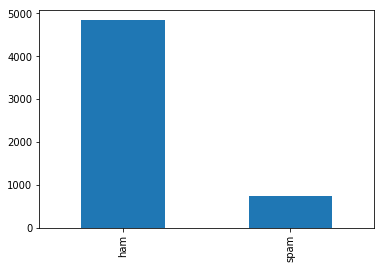

In [11]:
dataset.type.value_counts().plot.bar();

In [12]:
dataset["text"]= dataset["text"].astype(str)

## Preprocesamiento de los datos

En el preprocesamiento se tendran en cuenta dos fases.

* Limpieza del dataset por medio de funciones, eliminando numeros, tags, paginas, caracteres especiales, espacios, tabs, etc.

* Aplicacion de un stemmer propuesto por el profesor, el cual es un algoritmo para reducir una palabra y eliminar conjugaciones.

In [13]:
def remove_special_characters(text):
    return re.sub("[^A-Za-z0-9]+", " ", text)

def remove_tags(text):
    content = text[1]
    TAG_RE = re.compile(r'<[^>]+>')
    TAG_REX = re.compile(r"\s+")
    content = TAG_RE.sub('', content)
    content = TAG_REX.sub(' ', content)
    return content

def remove_numbers(text):
    content = text[1]
    TAG_RE = re.compile(r'[0-9]*')
    return TAG_RE.sub('', content)

def remove_websites(text):
    content = text[1]
    TAG_RE = re.compile(r'https?:\/\/.*[\n]*')
    return TAG_RE.sub('', content)

def remove_space_tabs(text):
    content = text[1]
    return content.replace("\n","").strip("\t")

def remove_stop_words(text):
    from nltk.corpus import stopwords
    
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words_filtered = []

    for word in words:
        if word not in stop_words:
            words_filtered.append(word)
    
    return " ".join(words_filtered)

def transform_to_lowercase(text):
    return text.lower()

def remove_emails(text):
    return re.sub("[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.].+", "", text)

## PROCESO DE LIMPIEZA

Se aplica sobre el dataset multiples funciones para limpiar los string.

In [14]:
dataset['text'] = dataset.apply(remove_numbers, axis=1)
dataset['text'] = dataset.apply(remove_space_tabs, axis=1)
dataset['text'] = dataset.apply(remove_websites, axis=1)
dataset['text'] = dataset.apply(remove_tags, axis=1)

for index, row in dataset.iterrows():
    dataset['text'][index] = transform_to_lowercase(dataset['text'][index])
    dataset['text'][index] = remove_special_characters(dataset['text'][index])
    dataset['text'][index] = remove_stop_words(dataset['text'][index])
    dataset['text'][index] = remove_emails(dataset['text'][index])
    
dataset.head(20)

,type,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah think goes usf lives around though
5,spam,freemsg hey darling week word back like fun st...
6,ham,even brother like speak treat like aids patent
7,ham,per request melle melle oru minnaminunginte nu...
8,spam,winner valued network customer selected receiv...
9,spam,mobile months u r entitled update latest colou...


## APLICACION DE STEMMER.

In [15]:
# Aplicacion del stemmer.
stemmer = PorterStemmer()
dataset['stemmed'] = dataset.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))
dataset.head(20)

,type,text,stemmed
0,ham,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,ham,ok lar joking wif u oni,ok lar joke wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...,free entri wkli comp win fa cup final tkt st m...
3,ham,u dun say early hor u c already say,u dun say earli hor u c alreadi say
4,ham,nah think goes usf lives around though,nah think goe usf live around though
5,spam,freemsg hey darling week word back like fun st...,freemsg hey darl week word back like fun still...
6,ham,even brother like speak treat like aids patent,even brother like speak treat like aid patent
7,ham,per request melle melle oru minnaminunginte nu...,per request mell mell oru minnaminungint nurun...
8,spam,winner valued network customer selected receiv...,winner valu network custom select receivea pri...
9,spam,mobile months u r entitled update latest colou...,mobil month u r entitl updat latest colour mob...


## Normalizacion de los datos ( Bag of words).

In [51]:
count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(dataset.stemmed)

vocabulary = count_vect.get_feature_names()

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5574, 1397)

In [52]:
vocabulary[0:40]  # PRIMERAS 40 PALABRAS APRENDIDAS DE LOS MENSAJES DE TEXT0

['aathi',
 'abiola',
 'abl',
 'abt',
 'ac',
 'acc',
 'accept',
 'access',
 'account',
 'act',
 'activ',
 'actual',
 'ad',
 'add',
 'address',
 'admir',
 'ador',
 'adult',
 'advanc',
 'advic',
 'affair',
 'affect',
 'aft',
 'afternoon',
 'aftr',
 'age',
 'ago',
 'ah',
 'aha',
 'ahead',
 'ahmad',
 'aight',
 'air',
 'airport',
 'aiyah',
 'aiyo',
 'al',
 'alert',
 'alex',
 'allah']

In [53]:
##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', dataset.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  go jurong point crazy available bugis n great world la e buffet cine got amore wat
Mod:  avail bugi cine crazi got great la point wat world

Org:  ok lar joking wif u oni
Mod:  joke lar ok wif

Org:  free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
Mod:  appli comp cup entri final free question rate receiv st std text txt win wkli

Org:  u dun say early hor u c already say
Mod:  alreadi dun earli say

Org:  nah think goes usf lives around though
Mod:  goe live nah think usf

Org:  freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv
Mod:  darl freemsg fun hey like ok send std tb week word xxx

Org:  even brother like speak treat like aids patent
Mod:  brother like speak treat

Org:  per request melle melle oru minnaminunginte nurungu vettam set callertune callers press copy friends callertune
Mod:  caller callertun copi friend press request set

Org:  winner valued network customer selected receivea pri

# Division de datos de entrenamiento y prueba.

* 75 % Datos de entrenamiento

* 25 % Datos de prueba

Por medio de CROSS-VALIDATION, se parten los segmentos, se toma el primer 75 % del total de los datos de entrenamiento y de prueba se deja el ultimo 25%.


In [54]:
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      = dtm[0:4168,]  # 75 % datos de entrenamiento 
X_test       = dtm[4169:,]  # 25% datos de prueba
y_train_true = dataset.type[0:4168]
y_test_true  = dataset.type[4169:]

In [55]:
##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_train_true.value_counts() / sum(y_train_true.value_counts()), 1)

ham     86.5
spam    13.5
Name: type, dtype: float64

In [56]:
##
## Distribución de los datos en el conjunto de testing.
##
round(100 * y_test_true.value_counts() / sum(y_test_true.value_counts()), 1)

ham     87.0
spam    13.0
Name: type, dtype: float64

## Regresion Logistica

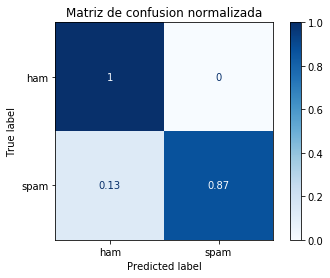

In [57]:
modelo_base = LogisticRegression(random_state=123)


'''
    Entrenamos el clasificador.
'''

modelo_base.fit(X_train.toarray(), y_train_true)


cm = plot_confusion_matrix(modelo_base, X_test, y_test_true,
                           display_labels=['ham', 'spam'],
                           cmap=plt.cm.Blues,
                           normalize='true')
cm.ax_.set_title("Matriz de confusion normalizada")
plt.show()

In [58]:
'''
    PRONOSTICAMOS PARA LOS DATOS DE PRUEBA
'''

y_test_pred = modelo_base.predict(X_test.toarray())
y_test_pred_prob = modelo_base.predict_proba(X_test.toarray())
y_test_pred

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [63]:
'''
    MATRIZ DE CONFUSIÓN
'''

matriz_confusion = confusion_matrix(y_true = y_test_true,
                                    y_pred = y_test_pred)


matriz_confusion

array([[1222,    0],
       [  24,  159]])

## MÉTRICAS DE PRECISIÓN Y EXACTITUD

Dados los resultados de la matriz de confusion podemos revisar algunas metricas interesantes como la exactitud y la presicion.

In [67]:


VERDADEROS_POSITIVOS = matriz_confusion[0][0]
FALSOS_NEGATIVOS = matriz_confusion[0][1]
FALSOS_POSITIVOS = matriz_confusion[1][0]
VERDADEROS_NEGATIVOS = matriz_confusion[1][1]


exactitud = (VERDADEROS_POSITIVOS + VERDADEROS_NEGATIVOS ) / (VERDADEROS_POSITIVOS + FALSOS_NEGATIVOS + FALSOS_POSITIVOS + VERDADEROS_NEGATIVOS )
precision = VERDADEROS_POSITIVOS / ( VERDADEROS_POSITIVOS + FALSOS_POSITIVOS)
print('EXACTITUD' , exactitud)
print('PRESICION', precision)

EXACTITUD 0.9829181494661922
PRESICION 0.9807383627608347


In [68]:
modelo_base.predict_proba(X_test.toarray())

array([[0.00382467, 0.99617533],
       [0.90312686, 0.09687314],
       [0.8879949 , 0.1120051 ],
       ...,
       [0.98244087, 0.01755913],
       [0.89148181, 0.10851819],
       [0.97912381, 0.02087619]])

In [69]:
results = pd.DataFrame(data = {
    'actual_type':  y_test_true,
    'predict_type': y_test_pred,
    'prob_ham':     [v[0] for v in y_test_pred_prob],
    'prob_spam':    [v[1] for v in y_test_pred_prob]})

results.head(5)

,actual_type,predict_type,prob_ham,prob_spam
4169,spam,spam,0.003825,0.996175
4170,ham,ham,0.903127,0.096873
4171,ham,ham,0.887995,0.112005
4172,ham,ham,0.999678,0.000322
4173,ham,ham,0.994447,0.005553


Podemos revisar los mensajes que tuvieron una CLASIFICACIÓN ERRÓNEA.

In [70]:
'''
 Mensajes con CLASIFICACIÓN ERRÓNEA.
'''

results[results['actual_type'] != results['predict_type']]

,actual_type,predict_type,prob_ham,prob_spam
4213,spam,ham,0.928527,0.071473
4249,spam,ham,0.736396,0.263604
4256,spam,ham,0.517119,0.482881
4258,spam,ham,0.533507,0.466493
4295,spam,ham,0.934810,0.065190
4355,spam,ham,0.533507,0.466493
4373,spam,ham,0.691552,0.308448
4394,spam,ham,0.804606,0.195394
4475,spam,ham,0.761925,0.238075
4506,spam,ham,0.894812,0.105188


### CLASIFICACION CON REDES NEURONALES

Procedemos a usar el PERCEPTRON que es con un clasificador lineal y se varia el numero de NEURONAS En la capa oculta.

In [85]:
rkf = RepeatedKFold(n_splits=10, random_state=1)
X  = dtm[:,]
Y = dataset.type
resultado_modelo = pd.DataFrame(columns = ["error_validacion",
                                           "error_entrenamiento",
                                           "neuronas_capa_oculta"])

modelos = {}
## CANTIDAD DE NEURONAS CAPA OCULTA.
for neuronas_capa_oculta in range(1,30):
    breakingFlag=False
    model = MLPClassifier(activation='relu', 
                          hidden_layer_sizes=(neuronas_capa_oculta,), 
                          learning_rate='adaptive',
                          learning_rate_init=0.001, 
                          random_state=1, 
                          shuffle=True,
                          warm_start=True,
                          max_iter=10000)
    modelos[neuronas_capa_oculta] = model
    Y_tested = []
    Y_predicted = []
    error_entrenamiento = 0
    error_validacion = 0
    total_fits=0
    for train, test in rkf.split(X):
        ### Entrenamiento.
        X_train = X[train]
        Y_train = Y[train]
        X_test = X[test]
        Y_test = Y[test]
        modelos[neuronas_capa_oculta].fit(X_train,Y_train)
        error_entrenamiento = error_entrenamiento + model.loss_
        total_fits = total_fits + 1
        Y_pred = modelos[neuronas_capa_oculta].predict(X_test)
        error_validacion = error_validacion + accuracy_score(Y_test,Y_pred)
                                                                             
    resultado_modelo = resultado_modelo.append({
        "error_validacion": error_validacion,
        "error_entrenamiento": error_entrenamiento,
        "neuronas_capa_oculta": neuronas_capa_oculta,
    },ignore_index=True)
    
resultado_modelo

,error_validacion,error_entrenamiento,neuronas_capa_oculta
0,99.741652,1.894237,1.0
1,99.897747,0.947141,2.0
2,99.852915,0.703336,3.0
3,99.858281,0.665692,4.0
4,99.894169,0.619037,5.0
5,99.869037,0.548857,6.0
6,99.865463,0.559226,7.0
7,99.849318,0.574237,8.0
8,99.903120,0.543040,9.0
9,99.878017,0.518955,10.0


In [86]:
mejor_entrenamiento = resultado_modelo[resultado_modelo['error_entrenamiento'] == resultado_modelo['error_entrenamiento'].max()] ##Mejor entrenamiento
mejor_entrenamiento

,error_validacion,error_entrenamiento,neuronas_capa_oculta
26,99.922855,0.382188,27.0


In [99]:
mejor_validacion = resultado_modelo[resultado_modelo['error_validacion'] == resultado_modelo['error_validacion'].min()] ##Mejor entrenamiento
mejor_validacion

,error_validacion,error_entrenamiento,neuronas_capa_oculta
0,99.741652,1.894237,1.0


Con el numero de neuronas en la capa oculta = 1, se tiene el mejor error de validacion.
Sin embargo el clasificador funciona bien con el error de entrenamiento teniendo en cuenta los errores para cada cantidad de neuronas.

DECISIÓN: Usar el clasificador con una neurona en la capa oculta.


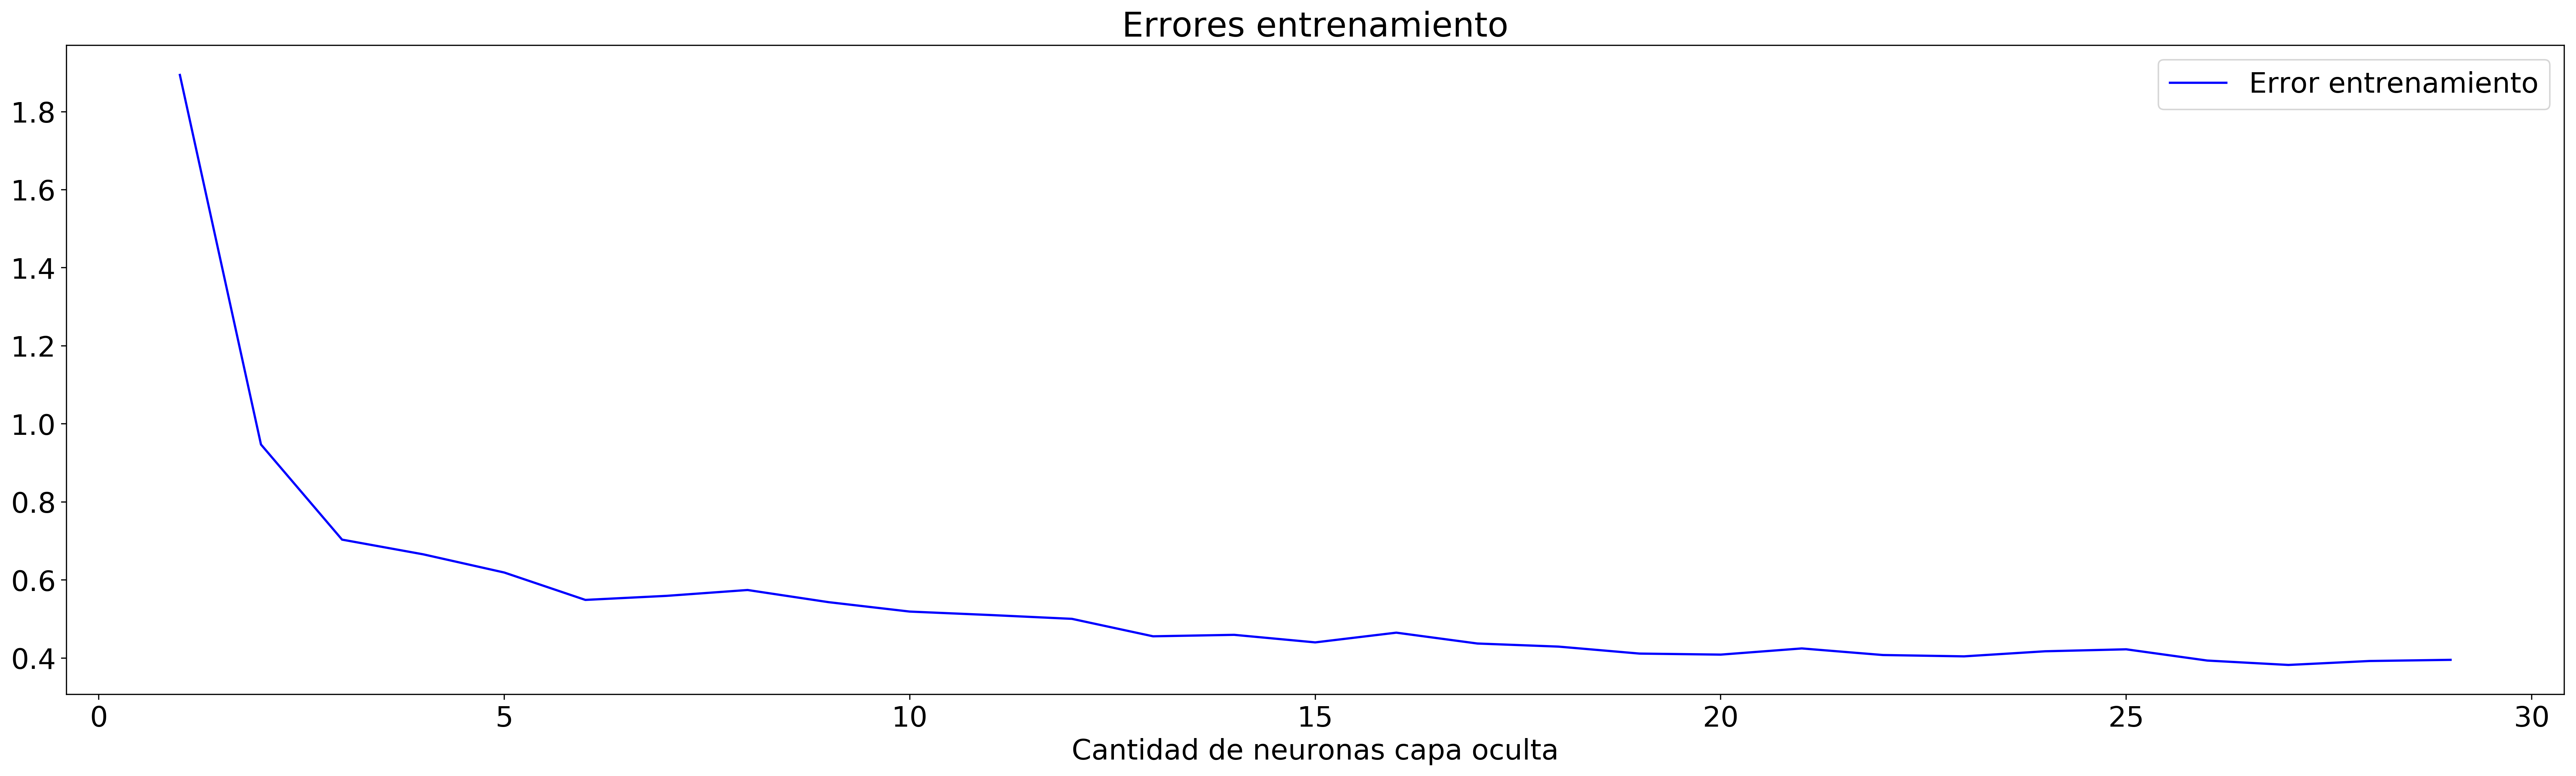

In [100]:
figure(num=None, figsize=(30,8), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.title('Errores entrenamiento')
plt.plot(resultado_modelo['neuronas_capa_oculta'], resultado_modelo['error_entrenamiento'], label="Error entrenamiento", color = "blue")
plt.xlabel('Cantidad de neuronas capa oculta')
plt.legend()
plt.show()

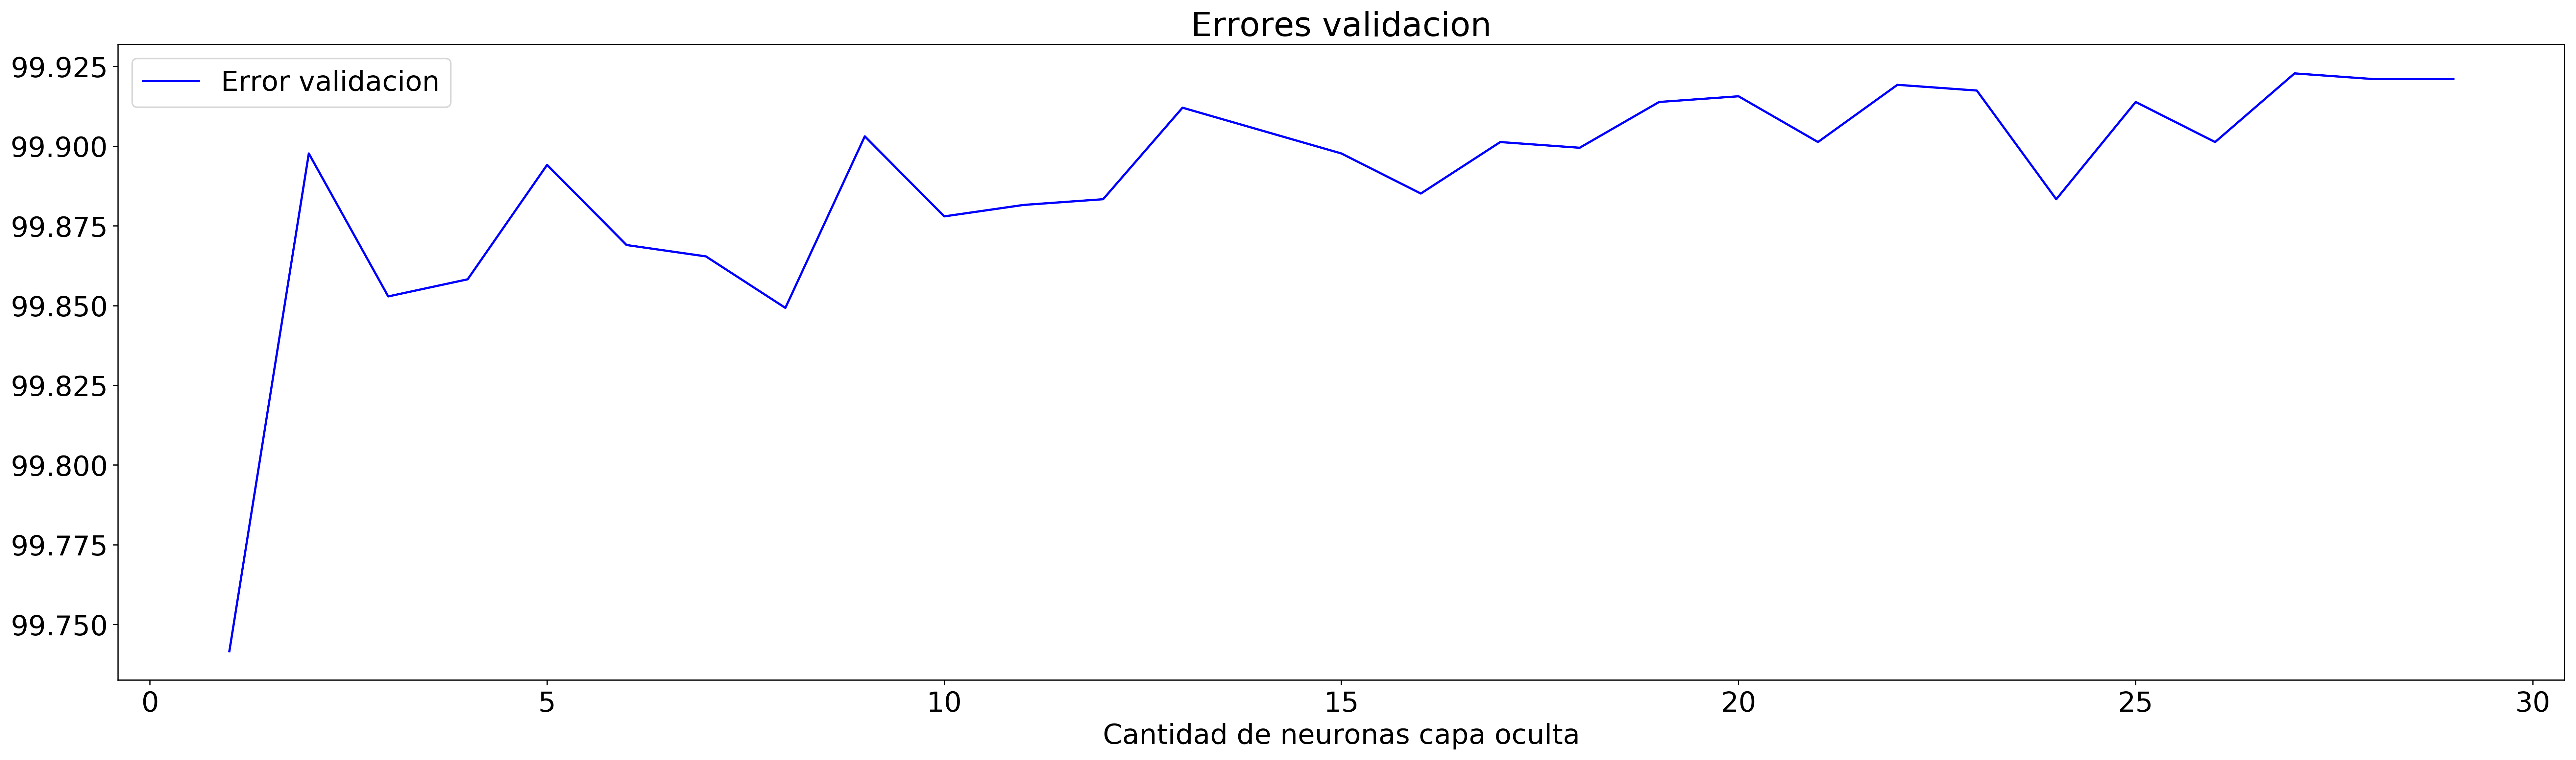

In [101]:
figure(num=None, figsize=(30,8), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.title('Errores validacion')
plt.plot(resultado_modelo['neuronas_capa_oculta'], resultado_modelo['error_validacion'], label="Error validacion", color = "blue")
plt.xlabel('Cantidad de neuronas capa oculta')
plt.legend()
plt.show()

### CROSS-VALIDATION RED NEURONAL

In [103]:
'''
 PREDICCION DEL MODELO TENIENDO EN CUENTA CROSS-VALIDATION QUE SE HIZO ANTERIORMENTE PARA LA REGRESION LOGISTICA

'''


X_train      = dtm[0:4168,] # 75 % de los datos
X_test       = dtm[4169:,] # 25 % de los datos.
y_train_true = dataset.type[0:4168]
y_test_true  = dataset.type[4169:]


y_test_pred = modelos[1].predict(X_test.toarray())
y_test_pred_prob = modelos[1].predict_proba(X_test.toarray())
y_test_pred

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

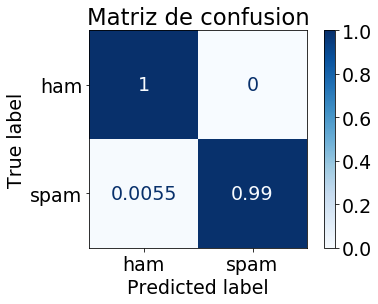

In [104]:
cm = plot_confusion_matrix(modelos[1], X_test, y_test_true,
                           display_labels=['ham', 'spam'],
                           cmap=plt.cm.Blues,
                           normalize='true')
cm.ax_.set_title("Matriz de confusion")
plt.show()

### MATRIZ DE CONFUSION

![title](datos/matriz_confusion.png)

In [109]:
'''
    MATRIZ DE CONFUSIÓN
'''

matriz_confusion = confusion_matrix(y_true = y_test_true,
                                    y_pred = y_test_pred)

### METRICAS.

In [110]:
VERDADEROS_POSITIVOS = matriz_confusion[0][0]
FALSOS_NEGATIVOS = matriz_confusion[0][1]
FALSOS_POSITIVOS = matriz_confusion[1][0]
VERDADEROS_NEGATIVOS = matriz_confusion[1][1]


exactitud = (VERDADEROS_POSITIVOS + VERDADEROS_NEGATIVOS ) / (VERDADEROS_POSITIVOS + FALSOS_NEGATIVOS + FALSOS_POSITIVOS + VERDADEROS_NEGATIVOS )
precision = VERDADEROS_POSITIVOS / ( VERDADEROS_POSITIVOS + FALSOS_POSITIVOS)
print('EXACTITUD' , exactitud)
print('PRESICION', precision)

EXACTITUD 0.999288256227758
PRESICION 0.9991823385118561


### CONCLUSION

Se concluye que el modelo con la mejor exactitud y precisión es el clasificador perceptrón puesto que presenta métricas de mejor exactitud y precisión dada su matriz de confusión, para este caso el número de neuronas en la capa oculta es igual a 1 para lograr el mejor error.

La regresión logística también funciona bien y devuelve métricas favorables para el modelo, aún así el clasificador logra mejor exactitud y precisión.


* Modelo ganador.

NUMERO DE NEURONAS CAPA OCULTA = 1.
RED NEURONAL PERCEPTRÓN - CLASIFICADOR SPAM.
